In [1]:
#Import the libraries
import math
import sys
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras import activations
import tensorflowjs as tfjs
from sklearn.model_selection import GridSearchCV
plt.style.use('fivethirtyeight')
import csv

In [2]:
df = pd.read_csv('covid_data.csv')
df["Tanggal"] = pd.to_datetime(df["Tanggal"])
filtered_date = df["Tanggal"].between('2021-01-01', '2022-01-01')

In [3]:
df = df[filtered_date].filter(['Tanggal','Positif Harian','Meninggal'])
# df.head()

print("shape: ", df.shape)

shape:  (366, 3)


In [4]:
train_dates = pd.to_datetime(df['Tanggal'])
train_dates.shape

(366,)

In [5]:
df

,Tanggal,Positif Harian,Meninggal
306,2021-01-01,1956,3308
307,2021-02-01,1895,3334
308,2021-03-01,1657,3345
309,2021-04-01,1832,3369
310,2021-05-01,1824,3392
...,...,...,...
667,2021-12-28,96,13585
668,2021-12-29,27,13587
669,2021-12-30,53,13587
670,2021-12-31,87,13588


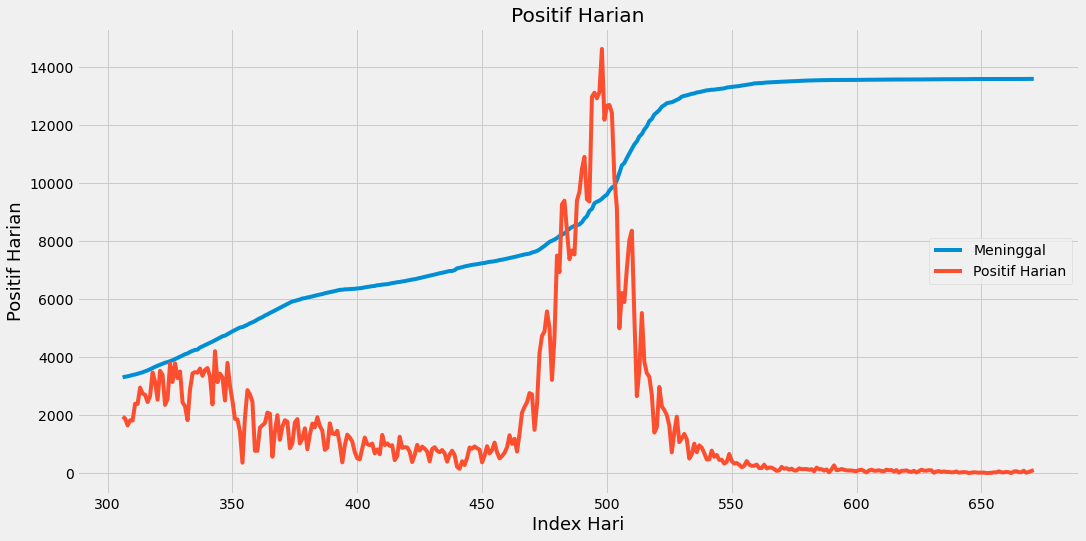

In [6]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Positif Harian')
plt.plot(df[["Meninggal","Positif Harian"]])
plt.xlabel('Index Hari',fontsize=18)
plt.ylabel('Positif Harian',fontsize=18)
plt.legend(['Meninggal', 'Positif Harian'], loc='right')

plt.show()


In [7]:
dataset = df[["Meninggal","Positif Harian"]].values
# print("data: ", dataset)
training_data_len = math.ceil( len(dataset) *.8)
training_data_len

293

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [9]:
train_data = scaled_data[0:training_data_len  , : ]

# print(train_data)

In [10]:
based_days = 7
x_train = []
y_train = []

for i in range(based_days, len(train_data)):
    x_train.append(train_data[i-based_days:i, 0:2])
    y_train.append(train_data[i,0:2])
    
x_train, y_train = np.array(x_train), np.array(y_train)

print('x_train shape == {}.'.format(x_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

x_train shape == (286, 7, 2).
y_train shape == (286, 2).


In [11]:
print("Shape x_train: ", x_train.shape)
# print(x_train)

Shape x_train:  (286, 7, 2)


In [12]:
print("Shape y_train: ", y_train.shape)
# print(y_train)

Shape y_train:  (286, 2)


In [13]:
def define_model_grid (dropout_rate, first_neuron, second_neuron):
    model_gscv = Sequential()
    model_gscv.add(LSTM(first_neuron, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
    model_gscv.add(Dropout(dropout_rate))
    model_gscv.add(LSTM(second_neuron, return_sequences=False))
    model_gscv.add(Dense(y_train.shape[1]))
    model_gscv.compile(optimizer='adam', loss='mean_squared_error', metrics=['acc'])
    # model_gscv.summary()
    
    return model_gscv

In [14]:
from keras.wrappers.scikit_learn import KerasClassifier

model_gcsv = KerasClassifier(build_fn=define_model_grid, verbose=1)

dropout_rate = [0.2, 0.3, 0.4]
first_neuron = [128, 64, 32]
second_neuron = [128, 64, 32]
batch_size = [10, 20, 30]
epochs = [20, 25]

C:\Users\cendr\AppData\Local\Temp/ipykernel_26592/4056094321.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_gcsv = KerasClassifier(build_fn=define_model_grid, verbose=1)


In [15]:
param_grid = dict(dropout_rate = dropout_rate, first_neuron = first_neuron, second_neuron = second_neuron, batch_size = batch_size, epochs = epochs)

In [16]:
grid = GridSearchCV(estimator=model_gcsv, param_grid=param_grid, cv=3)

In [17]:
print('trainX shape == {}.'.format(x_train.shape))
print('trainY shape == {}.'.format(y_train.shape))
# grid_result = grid.fit(x_train, y_train) #start training

trainX shape == (286, 7, 2).
trainY shape == (286, 2).


In [18]:
#summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("Mean = %f (std=%f) with: %r" % (mean, stdev, param))
    

# Best: 0.847039 using {'batch_size': 30, 'dropout_rate': 0.3, 'epochs': 20, 'first_neuron': 32, 'second_neuron': 32}
# Mean = 0.815789 (std=0.224328) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 20, 'first_neuron': 128, 'second_neuron': 128}
# Mean = 0.805336 (std=0.232074) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 20, 'first_neuron': 128, 'second_neuron': 64}
# Mean = 0.826133 (std=0.196103) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 20, 'first_neuron': 128, 'second_neuron': 32}
# Mean = 0.812281 (std=0.222316) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 20, 'first_neuron': 64, 'second_neuron': 128}
# Mean = 0.819225 (std=0.212564) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 20, 'first_neuron': 64, 'second_neuron': 64}
# Mean = 0.826133 (std=0.196103) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 20, 'first_neuron': 64, 'second_neuron': 32}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 20, 'first_neuron': 32, 'second_neuron': 128}
# Mean = 0.826133 (std=0.196103) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 20, 'first_neuron': 32, 'second_neuron': 64}
# Mean = 0.833114 (std=0.193082) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 20, 'first_neuron': 32, 'second_neuron': 32}
# Mean = 0.805336 (std=0.232074) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 25, 'first_neuron': 128, 'second_neuron': 128}
# Mean = 0.801827 (std=0.230130) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 25, 'first_neuron': 128, 'second_neuron': 64}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 25, 'first_neuron': 128, 'second_neuron': 32}
# Mean = 0.815753 (std=0.217439) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 25, 'first_neuron': 64, 'second_neuron': 128}
# Mean = 0.819189 (std=0.205814) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 25, 'first_neuron': 64, 'second_neuron': 64}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 25, 'first_neuron': 64, 'second_neuron': 32}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 25, 'first_neuron': 32, 'second_neuron': 128}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 25, 'first_neuron': 32, 'second_neuron': 64}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 25, 'first_neuron': 32, 'second_neuron': 32}
# Mean = 0.805336 (std=0.232074) with: {'batch_size': 10, 'dropout_rate': 0.3, 'epochs': 20, 'first_neuron': 128, 'second_neuron': 128}
# Mean = 0.815789 (std=0.224328) with: {'batch_size': 10, 'dropout_rate': 0.3, 'epochs': 20, 'first_neuron': 128, 'second_neuron': 64}
# Mean = 0.808808 (std=0.227194) with: {'batch_size': 10, 'dropout_rate': 0.3, 'epochs': 20, 'first_neuron': 128, 'second_neuron': 32}
# Mean = 0.808808 (std=0.227194) with: {'batch_size': 10, 'dropout_rate': 0.3, 'epochs': 20, 'first_neuron': 64, 'second_neuron': 128}
# Mean = 0.833114 (std=0.193082) with: {'batch_size': 10, 'dropout_rate': 0.3, 'epochs': 20, 'first_neuron': 64, 'second_neuron': 64}
# Mean = 0.826133 (std=0.196103) with: {'batch_size': 10, 'dropout_rate': 0.3, 'epochs': 20, 'first_neuron': 64, 'second_neuron': 32}
# Mean = 0.812281 (std=0.222316) with: {'batch_size': 10, 'dropout_rate': 0.3, 'epochs': 20, 'first_neuron': 32, 'second_neuron': 128}
# Mean = 0.833114 (std=0.193082) with: {'batch_size': 10, 'dropout_rate': 0.3, 'epochs': 20, 'first_neuron': 32, 'second_neuron': 64}
# Mean = 0.833114 (std=0.193082) with: {'batch_size': 10, 'dropout_rate': 0.3, 'epochs': 20, 'first_neuron': 32, 'second_neuron': 32}
# Mean = 0.801827 (std=0.230130) with: {'batch_size': 10, 'dropout_rate': 0.3, 'epochs': 25, 'first_neuron': 128, 'second_neuron': 128}
# Mean = 0.798355 (std=0.234999) with: {'batch_size': 10, 'dropout_rate': 0.3, 'epochs': 25, 'first_neuron': 128, 'second_neuron': 64}
# Mean = 0.826170 (std=0.202820) with: {'batch_size': 10, 'dropout_rate': 0.3, 'epochs': 25, 'first_neuron': 128, 'second_neuron': 32}
# Mean = 0.826170 (std=0.202820) with: {'batch_size': 10, 'dropout_rate': 0.3, 'epochs': 25, 'first_neuron': 64, 'second_neuron': 128}
# Mean = 0.812317 (std=0.229217) with: {'batch_size': 10, 'dropout_rate': 0.3, 'epochs': 25, 'first_neuron': 64, 'second_neuron': 64}
# Mean = 0.819189 (std=0.205814) with: {'batch_size': 10, 'dropout_rate': 0.3, 'epochs': 25, 'first_neuron': 64, 'second_neuron': 32}
# Mean = 0.826133 (std=0.196103) with: {'batch_size': 10, 'dropout_rate': 0.3, 'epochs': 25, 'first_neuron': 32, 'second_neuron': 128}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 10, 'dropout_rate': 0.3, 'epochs': 25, 'first_neuron': 32, 'second_neuron': 64}
# Mean = 0.826133 (std=0.196103) with: {'batch_size': 10, 'dropout_rate': 0.3, 'epochs': 25, 'first_neuron': 32, 'second_neuron': 32}
# Mean = 0.812317 (std=0.229217) with: {'batch_size': 10, 'dropout_rate': 0.4, 'epochs': 20, 'first_neuron': 128, 'second_neuron': 128}
# Mean = 0.805373 (std=0.238996) with: {'batch_size': 10, 'dropout_rate': 0.4, 'epochs': 20, 'first_neuron': 128, 'second_neuron': 64}
# Mean = 0.805300 (std=0.225263) with: {'batch_size': 10, 'dropout_rate': 0.4, 'epochs': 20, 'first_neuron': 128, 'second_neuron': 32}
# Mean = 0.805373 (std=0.238996) with: {'batch_size': 10, 'dropout_rate': 0.4, 'epochs': 20, 'first_neuron': 64, 'second_neuron': 128}
# Mean = 0.826170 (std=0.202820) with: {'batch_size': 10, 'dropout_rate': 0.4, 'epochs': 20, 'first_neuron': 64, 'second_neuron': 64}
# Mean = 0.826133 (std=0.196103) with: {'batch_size': 10, 'dropout_rate': 0.4, 'epochs': 20, 'first_neuron': 64, 'second_neuron': 32}
# Mean = 0.808845 (std=0.234106) with: {'batch_size': 10, 'dropout_rate': 0.4, 'epochs': 20, 'first_neuron': 32, 'second_neuron': 128}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 10, 'dropout_rate': 0.4, 'epochs': 20, 'first_neuron': 32, 'second_neuron': 64}
# Mean = 0.826133 (std=0.196103) with: {'batch_size': 10, 'dropout_rate': 0.4, 'epochs': 20, 'first_neuron': 32, 'second_neuron': 32}
# Mean = 0.798319 (std=0.228278) with: {'batch_size': 10, 'dropout_rate': 0.4, 'epochs': 25, 'first_neuron': 128, 'second_neuron': 128}
# Mean = 0.791411 (std=0.244743) with: {'batch_size': 10, 'dropout_rate': 0.4, 'epochs': 25, 'first_neuron': 128, 'second_neuron': 64}
# Mean = 0.787866 (std=0.236202) with: {'batch_size': 10, 'dropout_rate': 0.4, 'epochs': 25, 'first_neuron': 128, 'second_neuron': 32}
# Mean = 0.798355 (std=0.234999) with: {'batch_size': 10, 'dropout_rate': 0.4, 'epochs': 25, 'first_neuron': 64, 'second_neuron': 128}
# Mean = 0.812281 (std=0.222316) with: {'batch_size': 10, 'dropout_rate': 0.4, 'epochs': 25, 'first_neuron': 64, 'second_neuron': 64}
# Mean = 0.822624 (std=0.194366) with: {'batch_size': 10, 'dropout_rate': 0.4, 'epochs': 25, 'first_neuron': 64, 'second_neuron': 32}
# Mean = 0.805336 (std=0.232074) with: {'batch_size': 10, 'dropout_rate': 0.4, 'epochs': 25, 'first_neuron': 32, 'second_neuron': 128}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 10, 'dropout_rate': 0.4, 'epochs': 25, 'first_neuron': 32, 'second_neuron': 64}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 10, 'dropout_rate': 0.4, 'epochs': 25, 'first_neuron': 32, 'second_neuron': 32}
# Mean = 0.829678 (std=0.204785) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 20, 'first_neuron': 128, 'second_neuron': 128}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 20, 'first_neuron': 128, 'second_neuron': 64}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 20, 'first_neuron': 128, 'second_neuron': 32}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 20, 'first_neuron': 64, 'second_neuron': 128}
# Mean = 0.836623 (std=0.195021) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 20, 'first_neuron': 64, 'second_neuron': 64}
# Mean = 0.836623 (std=0.195021) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 20, 'first_neuron': 64, 'second_neuron': 32}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 20, 'first_neuron': 32, 'second_neuron': 128}
# Mean = 0.833114 (std=0.193082) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 20, 'first_neuron': 32, 'second_neuron': 64}
# Mean = 0.836586 (std=0.188217) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 20, 'first_neuron': 32, 'second_neuron': 32}
# Mean = 0.822697 (std=0.207691) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 25, 'first_neuron': 128, 'second_neuron': 128}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 25, 'first_neuron': 128, 'second_neuron': 64}
# Mean = 0.826170 (std=0.202820) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 25, 'first_neuron': 128, 'second_neuron': 32}
# Mean = 0.833114 (std=0.193082) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 25, 'first_neuron': 64, 'second_neuron': 128}
# Mean = 0.826170 (std=0.202820) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 25, 'first_neuron': 64, 'second_neuron': 64}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 25, 'first_neuron': 64, 'second_neuron': 32}
# Mean = 0.826170 (std=0.202820) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 25, 'first_neuron': 32, 'second_neuron': 128}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 25, 'first_neuron': 32, 'second_neuron': 64}
# Mean = 0.836586 (std=0.188217) with: {'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 25, 'first_neuron': 32, 'second_neuron': 32}
# Mean = 0.833151 (std=0.199903) with: {'batch_size': 20, 'dropout_rate': 0.3, 'epochs': 20, 'first_neuron': 128, 'second_neuron': 128}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 20, 'dropout_rate': 0.3, 'epochs': 20, 'first_neuron': 128, 'second_neuron': 64}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 20, 'dropout_rate': 0.3, 'epochs': 20, 'first_neuron': 128, 'second_neuron': 32}
# Mean = 0.833151 (std=0.199903) with: {'batch_size': 20, 'dropout_rate': 0.3, 'epochs': 20, 'first_neuron': 64, 'second_neuron': 128}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 20, 'dropout_rate': 0.3, 'epochs': 20, 'first_neuron': 64, 'second_neuron': 64}
# Mean = 0.833114 (std=0.193082) with: {'batch_size': 20, 'dropout_rate': 0.3, 'epochs': 20, 'first_neuron': 64, 'second_neuron': 32}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 20, 'dropout_rate': 0.3, 'epochs': 20, 'first_neuron': 32, 'second_neuron': 128}
# Mean = 0.833114 (std=0.193082) with: {'batch_size': 20, 'dropout_rate': 0.3, 'epochs': 20, 'first_neuron': 32, 'second_neuron': 64}
# Mean = 0.836586 (std=0.188217) with: {'batch_size': 20, 'dropout_rate': 0.3, 'epochs': 20, 'first_neuron': 32, 'second_neuron': 32}
# Mean = 0.808845 (std=0.234106) with: {'batch_size': 20, 'dropout_rate': 0.3, 'epochs': 25, 'first_neuron': 128, 'second_neuron': 128}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 20, 'dropout_rate': 0.3, 'epochs': 25, 'first_neuron': 128, 'second_neuron': 64}
# Mean = 0.826170 (std=0.202820) with: {'batch_size': 20, 'dropout_rate': 0.3, 'epochs': 25, 'first_neuron': 128, 'second_neuron': 32}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 20, 'dropout_rate': 0.3, 'epochs': 25, 'first_neuron': 64, 'second_neuron': 128}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 20, 'dropout_rate': 0.3, 'epochs': 25, 'first_neuron': 64, 'second_neuron': 64}
# Mean = 0.833114 (std=0.193082) with: {'batch_size': 20, 'dropout_rate': 0.3, 'epochs': 25, 'first_neuron': 64, 'second_neuron': 32}
# Mean = 0.826170 (std=0.202820) with: {'batch_size': 20, 'dropout_rate': 0.3, 'epochs': 25, 'first_neuron': 32, 'second_neuron': 128}
# Mean = 0.833114 (std=0.193082) with: {'batch_size': 20, 'dropout_rate': 0.3, 'epochs': 25, 'first_neuron': 32, 'second_neuron': 64}
# Mean = 0.833114 (std=0.193082) with: {'batch_size': 20, 'dropout_rate': 0.3, 'epochs': 25, 'first_neuron': 32, 'second_neuron': 32}
# Mean = 0.826170 (std=0.202820) with: {'batch_size': 20, 'dropout_rate': 0.4, 'epochs': 20, 'first_neuron': 128, 'second_neuron': 128}
# Mean = 0.833151 (std=0.199903) with: {'batch_size': 20, 'dropout_rate': 0.4, 'epochs': 20, 'first_neuron': 128, 'second_neuron': 64}
# Mean = 0.822661 (std=0.200957) with: {'batch_size': 20, 'dropout_rate': 0.4, 'epochs': 20, 'first_neuron': 128, 'second_neuron': 32}
# Mean = 0.833151 (std=0.199903) with: {'batch_size': 20, 'dropout_rate': 0.4, 'epochs': 20, 'first_neuron': 64, 'second_neuron': 128}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 20, 'dropout_rate': 0.4, 'epochs': 20, 'first_neuron': 64, 'second_neuron': 64}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 20, 'dropout_rate': 0.4, 'epochs': 20, 'first_neuron': 64, 'second_neuron': 32}
# Mean = 0.833151 (std=0.199903) with: {'batch_size': 20, 'dropout_rate': 0.4, 'epochs': 20, 'first_neuron': 32, 'second_neuron': 128}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 20, 'dropout_rate': 0.4, 'epochs': 20, 'first_neuron': 32, 'second_neuron': 64}
# Mean = 0.843567 (std=0.185263) with: {'batch_size': 20, 'dropout_rate': 0.4, 'epochs': 20, 'first_neuron': 32, 'second_neuron': 32}
# Mean = 0.805336 (std=0.232074) with: {'batch_size': 20, 'dropout_rate': 0.4, 'epochs': 25, 'first_neuron': 128, 'second_neuron': 128}
# Mean = 0.833114 (std=0.193082) with: {'batch_size': 20, 'dropout_rate': 0.4, 'epochs': 25, 'first_neuron': 128, 'second_neuron': 64}
# Mean = 0.826170 (std=0.202820) with: {'batch_size': 20, 'dropout_rate': 0.4, 'epochs': 25, 'first_neuron': 128, 'second_neuron': 32}
# Mean = 0.826170 (std=0.202820) with: {'batch_size': 20, 'dropout_rate': 0.4, 'epochs': 25, 'first_neuron': 64, 'second_neuron': 128}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 20, 'dropout_rate': 0.4, 'epochs': 25, 'first_neuron': 64, 'second_neuron': 64}
# Mean = 0.826133 (std=0.196103) with: {'batch_size': 20, 'dropout_rate': 0.4, 'epochs': 25, 'first_neuron': 64, 'second_neuron': 32}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 20, 'dropout_rate': 0.4, 'epochs': 25, 'first_neuron': 32, 'second_neuron': 128}
# Mean = 0.833114 (std=0.193082) with: {'batch_size': 20, 'dropout_rate': 0.4, 'epochs': 25, 'first_neuron': 32, 'second_neuron': 64}
# Mean = 0.840058 (std=0.183354) with: {'batch_size': 20, 'dropout_rate': 0.4, 'epochs': 25, 'first_neuron': 32, 'second_neuron': 32}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 30, 'dropout_rate': 0.2, 'epochs': 20, 'first_neuron': 128, 'second_neuron': 128}
# Mean = 0.833151 (std=0.199903) with: {'batch_size': 30, 'dropout_rate': 0.2, 'epochs': 20, 'first_neuron': 128, 'second_neuron': 64}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 30, 'dropout_rate': 0.2, 'epochs': 20, 'first_neuron': 128, 'second_neuron': 32}
# Mean = 0.833151 (std=0.199903) with: {'batch_size': 30, 'dropout_rate': 0.2, 'epochs': 20, 'first_neuron': 64, 'second_neuron': 128}
# Mean = 0.833114 (std=0.193082) with: {'batch_size': 30, 'dropout_rate': 0.2, 'epochs': 20, 'first_neuron': 64, 'second_neuron': 64}
# Mean = 0.833114 (std=0.193082) with: {'batch_size': 30, 'dropout_rate': 0.2, 'epochs': 20, 'first_neuron': 64, 'second_neuron': 32}
# Mean = 0.836623 (std=0.195021) with: {'batch_size': 30, 'dropout_rate': 0.2, 'epochs': 20, 'first_neuron': 32, 'second_neuron': 128}
# Mean = 0.836586 (std=0.188217) with: {'batch_size': 30, 'dropout_rate': 0.2, 'epochs': 20, 'first_neuron': 32, 'second_neuron': 64}
# Mean = 0.840095 (std=0.190142) with: {'batch_size': 30, 'dropout_rate': 0.2, 'epochs': 20, 'first_neuron': 32, 'second_neuron': 32}
# Mean = 0.833151 (std=0.199903) with: {'batch_size': 30, 'dropout_rate': 0.2, 'epochs': 25, 'first_neuron': 128, 'second_neuron': 128}
# Mean = 0.833151 (std=0.199903) with: {'batch_size': 30, 'dropout_rate': 0.2, 'epochs': 25, 'first_neuron': 128, 'second_neuron': 64}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 30, 'dropout_rate': 0.2, 'epochs': 25, 'first_neuron': 128, 'second_neuron': 32}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 30, 'dropout_rate': 0.2, 'epochs': 25, 'first_neuron': 64, 'second_neuron': 128}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 30, 'dropout_rate': 0.2, 'epochs': 25, 'first_neuron': 64, 'second_neuron': 64}
# Mean = 0.836623 (std=0.195021) with: {'batch_size': 30, 'dropout_rate': 0.2, 'epochs': 25, 'first_neuron': 64, 'second_neuron': 32}
# Mean = 0.833114 (std=0.193082) with: {'batch_size': 30, 'dropout_rate': 0.2, 'epochs': 25, 'first_neuron': 32, 'second_neuron': 128}
# Mean = 0.836586 (std=0.188217) with: {'batch_size': 30, 'dropout_rate': 0.2, 'epochs': 25, 'first_neuron': 32, 'second_neuron': 64}
# Mean = 0.836586 (std=0.188217) with: {'batch_size': 30, 'dropout_rate': 0.2, 'epochs': 25, 'first_neuron': 32, 'second_neuron': 32}
# Mean = 0.833151 (std=0.199903) with: {'batch_size': 30, 'dropout_rate': 0.3, 'epochs': 20, 'first_neuron': 128, 'second_neuron': 128}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 30, 'dropout_rate': 0.3, 'epochs': 20, 'first_neuron': 128, 'second_neuron': 64}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 30, 'dropout_rate': 0.3, 'epochs': 20, 'first_neuron': 128, 'second_neuron': 32}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 30, 'dropout_rate': 0.3, 'epochs': 20, 'first_neuron': 64, 'second_neuron': 128}
# Mean = 0.836623 (std=0.195021) with: {'batch_size': 30, 'dropout_rate': 0.3, 'epochs': 20, 'first_neuron': 64, 'second_neuron': 64}
# Mean = 0.833151 (std=0.199903) with: {'batch_size': 30, 'dropout_rate': 0.3, 'epochs': 20, 'first_neuron': 64, 'second_neuron': 32}
# Mean = 0.833151 (std=0.199903) with: {'batch_size': 30, 'dropout_rate': 0.3, 'epochs': 20, 'first_neuron': 32, 'second_neuron': 128}
# Mean = 0.840058 (std=0.183354) with: {'batch_size': 30, 'dropout_rate': 0.3, 'epochs': 20, 'first_neuron': 32, 'second_neuron': 64}
# Mean = 0.847039 (std=0.180387) with: {'batch_size': 30, 'dropout_rate': 0.3, 'epochs': 20, 'first_neuron': 32, 'second_neuron': 32}
# Mean = 0.826170 (std=0.202820) with: {'batch_size': 30, 'dropout_rate': 0.3, 'epochs': 25, 'first_neuron': 128, 'second_neuron': 128}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 30, 'dropout_rate': 0.3, 'epochs': 25, 'first_neuron': 128, 'second_neuron': 64}
# Mean = 0.826133 (std=0.196103) with: {'batch_size': 30, 'dropout_rate': 0.3, 'epochs': 25, 'first_neuron': 128, 'second_neuron': 32}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 30, 'dropout_rate': 0.3, 'epochs': 25, 'first_neuron': 64, 'second_neuron': 128}
# Mean = 0.833151 (std=0.199903) with: {'batch_size': 30, 'dropout_rate': 0.3, 'epochs': 25, 'first_neuron': 64, 'second_neuron': 64}
# Mean = 0.833114 (std=0.193082) with: {'batch_size': 30, 'dropout_rate': 0.3, 'epochs': 25, 'first_neuron': 64, 'second_neuron': 32}
# Mean = 0.833114 (std=0.193082) with: {'batch_size': 30, 'dropout_rate': 0.3, 'epochs': 25, 'first_neuron': 32, 'second_neuron': 128}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 30, 'dropout_rate': 0.3, 'epochs': 25, 'first_neuron': 32, 'second_neuron': 64}
# Mean = 0.833114 (std=0.193082) with: {'batch_size': 30, 'dropout_rate': 0.3, 'epochs': 25, 'first_neuron': 32, 'second_neuron': 32}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 30, 'dropout_rate': 0.4, 'epochs': 20, 'first_neuron': 128, 'second_neuron': 128}
# Mean = 0.829678 (std=0.204785) with: {'batch_size': 30, 'dropout_rate': 0.4, 'epochs': 20, 'first_neuron': 128, 'second_neuron': 64}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 30, 'dropout_rate': 0.4, 'epochs': 20, 'first_neuron': 128, 'second_neuron': 32}
# Mean = 0.833151 (std=0.199903) with: {'batch_size': 30, 'dropout_rate': 0.4, 'epochs': 20, 'first_neuron': 64, 'second_neuron': 128}
# Mean = 0.836623 (std=0.195021) with: {'batch_size': 30, 'dropout_rate': 0.4, 'epochs': 20, 'first_neuron': 64, 'second_neuron': 64}
# Mean = 0.836623 (std=0.195021) with: {'batch_size': 30, 'dropout_rate': 0.4, 'epochs': 20, 'first_neuron': 64, 'second_neuron': 32}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 30, 'dropout_rate': 0.4, 'epochs': 20, 'first_neuron': 32, 'second_neuron': 128}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 30, 'dropout_rate': 0.4, 'epochs': 20, 'first_neuron': 32, 'second_neuron': 64}
# Mean = 0.847003 (std=0.173636) with: {'batch_size': 30, 'dropout_rate': 0.4, 'epochs': 20, 'first_neuron': 32, 'second_neuron': 32}
# Mean = 0.826170 (std=0.202820) with: {'batch_size': 30, 'dropout_rate': 0.4, 'epochs': 25, 'first_neuron': 128, 'second_neuron': 128}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 30, 'dropout_rate': 0.4, 'epochs': 25, 'first_neuron': 128, 'second_neuron': 64}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 30, 'dropout_rate': 0.4, 'epochs': 25, 'first_neuron': 128, 'second_neuron': 32}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 30, 'dropout_rate': 0.4, 'epochs': 25, 'first_neuron': 64, 'second_neuron': 128}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 30, 'dropout_rate': 0.4, 'epochs': 25, 'first_neuron': 64, 'second_neuron': 64}
# Mean = 0.833114 (std=0.193082) with: {'batch_size': 30, 'dropout_rate': 0.4, 'epochs': 25, 'first_neuron': 64, 'second_neuron': 32}
# Mean = 0.829642 (std=0.197950) with: {'batch_size': 30, 'dropout_rate': 0.4, 'epochs': 25, 'first_neuron': 32, 'second_neuron': 128}
# Mean = 0.840095 (std=0.190142) with: {'batch_size': 30, 'dropout_rate': 0.4, 'epochs': 25, 'first_neuron': 32, 'second_neuron': 64}
# Mean = 0.833114 (std=0.193082) with: {'batch_size': 30, 'dropout_rate': 0.4, 'epochs': 25, 'first_neuron': 32, 'second_neuron': 32}


In [19]:
# grid_result.best_params_

#result:
# {'batch_size': 30,
#  'dropout_rate': 0.3,
#  'epochs': 20,
#  'first_neuron': 32,
#  'second_neuron': 32}

In [20]:
selected_model = Sequential()
selected_model.add(LSTM(32, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
selected_model.add(Dropout(0.3))
selected_model.add(LSTM(32, return_sequences=False))
selected_model.add(Dense(y_train.shape[1]))
selected_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['acc'])
selected_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 32)             4480      
                                                                 
 dropout (Dropout)           (None, 7, 32)             0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 12,866
Trainable params: 12,866
Non-trainable params: 0
_________________________________________________________________


In [21]:
selected_model.fit(x_train, y_train, batch_size=30, epochs=20)

Epoch 1/20
10/10 [==============================] - 4s 8ms/step - loss: 0.1499 - acc: 0.7797
Epoch 2/20
10/10 [==============================] - 0s 8ms/step - loss: 0.0540 - acc: 0.7762
Epoch 3/20
10/10 [==============================] - 0s 8ms/step - loss: 0.0290 - acc: 0.7762
Epoch 4/20
10/10 [==============================] - 0s 8ms/step - loss: 0.0216 - acc: 0.7762
Epoch 5/20
10/10 [==============================] - 0s 9ms/step - loss: 0.0127 - acc: 0.7832
Epoch 6/20
10/10 [==============================] - 0s 9ms/step - loss: 0.0070 - acc: 0.8741
Epoch 7/20
10/10 [==============================] - 0s 9ms/step - loss: 0.0056 - acc: 0.9336
Epoch 8/20
10/10 [==============================] - 0s 9ms/step - loss: 0.0056 - acc: 0.9406
Epoch 9/20
10/10 [==============================] - 0s 9ms/step - loss: 0.0048 - acc: 0.9371
Epoch 10/20
10/10 [==============================] - 0s 10ms/step - loss: 0.0048 - acc: 0.9301
Epoch 11/20
10/10 [==============================] - 0s 9ms/step - l

In [22]:
#Test data set
test_data = scaled_data[training_data_len - based_days: , : ]
# test_data = scaled_data[training_data_len: , : ]

In [23]:
x_test = []
y_test =  scaled_data[training_data_len: , : ]
for i in range(based_days, len(test_data)):
    x_test.append(test_data[i-based_days:i, 0:2])

In [24]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1], 2))
# y_test = np.array(y_test)

In [25]:
y_test = scaler.inverse_transform(y_test)
print("shape y_test: ", y_test.shape)
print("shape x_test: ", x_test.shape)

# print(y_test)
# print("y_train: ", y_train.shape)

shape y_test:  (73, 2)
shape x_test:  (73, 7, 2)


In [26]:
predictions_1 = selected_model.predict(x_test) 
predictions_1 = scaler.inverse_transform(predictions_1)#Undo scaling

In [27]:
#Calculate/Get the value of RMSE & MAPE
rmse_positif_1=np.sqrt(np.mean(((predictions_1[:, 1]- y_test[:, 1])**2)))
print("Model1 positif harian rmse: ", rmse_positif_1)

rmse_kematian_1=np.sqrt(np.mean(((predictions_1[:, 0]- y_test[:, 0])**2)))
print("Model1 kematian rmse: ", rmse_kematian_1)

print("-------------------------")

mape_positif_1 = np.mean(np.abs((predictions_1[:, 1] - y_test[:, 1]) / y_test[:, 1])) * 100
print("Model1 positif harian mape: ", mape_positif_1)

mape_kematian_1 = np.mean(np.abs((predictions_1[:, 0] - y_test[:, 0]) / y_test[:, 0])) * 100
print("Model1 kematian mape: ", mape_kematian_1)

Model1 positif harian rmse:  133.5867138620569
Model1 kematian rmse:  67.81160989787459
-------------------------
Model1 positif harian mape:  245.10962447523045
Model1 kematian mape:  0.4987458495942212


In [28]:
# selected_model.save("Best_Model/model_final.h5")

In [29]:
# from keras.models import load_model
# loaded_model_1 = load_model("Best_Model/model_final.h5")
# tfjs.converters.save_keras_model(loaded_model_1, "model_final_express")

In [30]:
# df

In [31]:
train= df.iloc[:training_data_len]
valid = df.iloc[training_data_len:]
valid['Predictions_Positif'] = predictions_1[:, 1].astype(int)
valid['Predictions_Meninggal'] = predictions_1[:, 0].astype(int)

C:\Users\cendr\AppData\Local\Temp/ipykernel_26592/2691821986.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions_Positif'] = predictions_1[:, 1].astype(int)
C:\Users\cendr\AppData\Local\Temp/ipykernel_26592/2691821986.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions_Meninggal'] = predictions_1[:, 0].astype(int)


In [32]:
# # with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
# #     print(train)
valid

,Tanggal,Positif Harian,Meninggal,Predictions_Positif,Predictions_Meninggal
599,2021-10-21,89,13553,-22,13493
600,2021-10-22,83,13553,-23,13493
601,2021-10-23,116,13555,-27,13493
602,2021-10-24,131,13556,-34,13492
603,2021-10-25,82,13557,-38,13493
...,...,...,...,...,...
667,2021-12-28,96,13585,-79,13515
668,2021-12-29,27,13587,-78,13515
669,2021-12-30,53,13587,-76,13515
670,2021-12-31,87,13588,-71,13516


In [33]:
# train

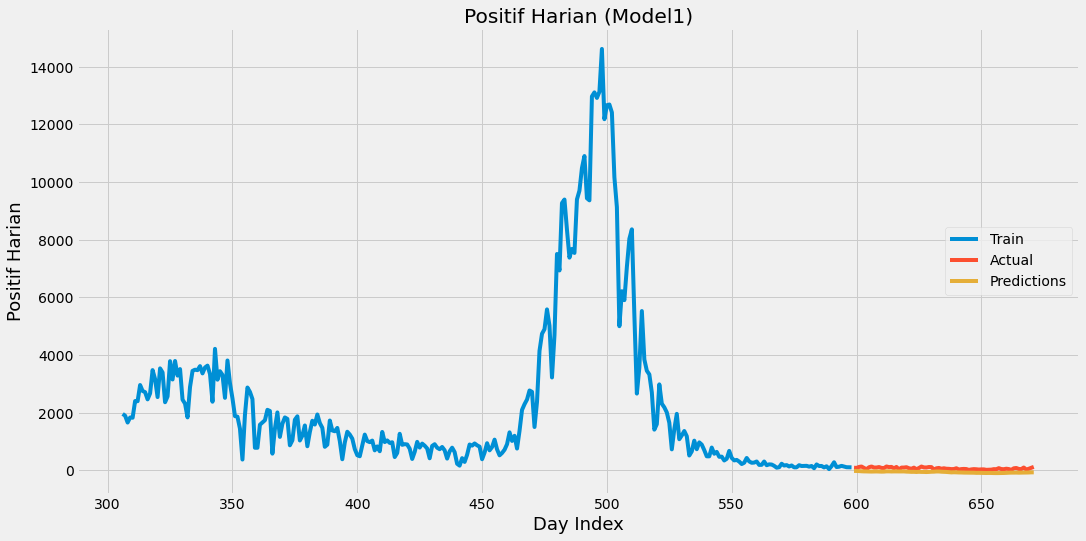

In [34]:
plt.figure(figsize=(16,8))
plt.title('Positif Harian (Model1)')
plt.xlabel('Day Index', fontsize=18)
plt.ylabel('Positif Harian', fontsize=18)
plt.plot(train['Positif Harian'])
plt.plot(valid[['Positif Harian', 'Predictions_Positif']])
plt.legend(['Train', 'Actual', 'Predictions'], loc='right')
plt.show()

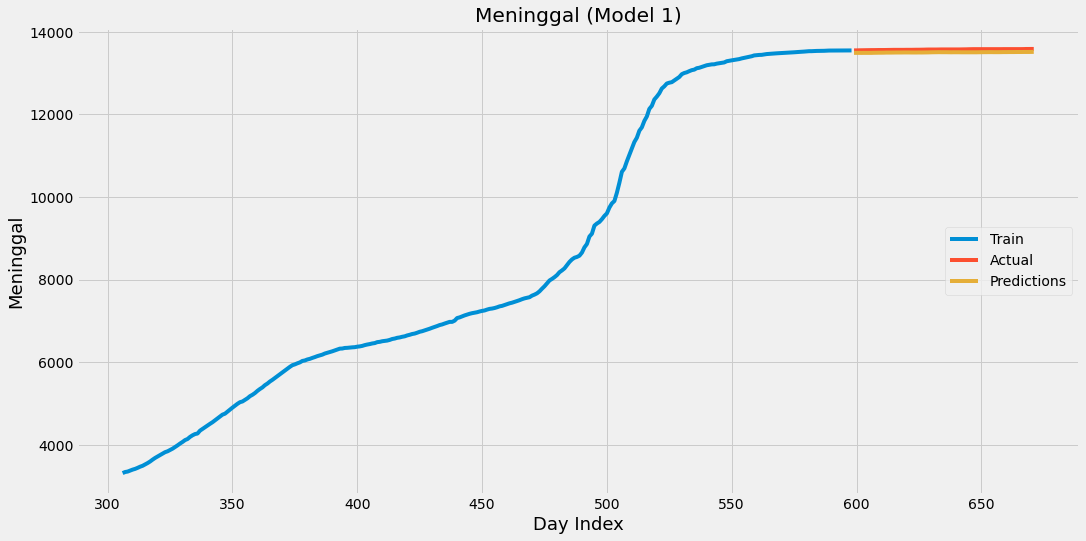

In [35]:
plt.figure(figsize=(16,8))
plt.title('Meninggal (Model 1)')
plt.xlabel('Day Index', fontsize=18)
plt.ylabel('Meninggal', fontsize=18)
plt.plot(train['Meninggal'])
plt.plot(valid[['Meninggal', 'Predictions_Meninggal']])
plt.legend(['Train', 'Actual', 'Predictions'], loc='right')
plt.show()

In [36]:
# selected_model.save("Best_Model/model_final.h5")

In [37]:
from keras.models import load_model
loaded_model_1 = load_model("Best_Model/model_final.h5")
load_predictions_1 = loaded_model_1.predict(x_test)
load_predictions_1 = scaler.inverse_transform(load_predictions_1)#Undo scaling

In [38]:
# #https://www.geeksforgeeks.org/how-to-calculate-mape-in-python/
# def rmse_calc(pred, actual, length):
#     print("pred: ", pred)
#     print("actual: ", actual)
#     print("len: ", length)
#     APE = []
#     for i in range(length):
#         # Calculate percentage error
#         per_err = (actual[i] - pred[i]) / actual[i]

#         # Take absolute value of
#         # the percentage error (APE)
#         per_err = abs(per_err)

#         # Append it to the APE list
#         APE.append(per_err)
    
#     return sum(APE)/len(APE) * 100
    

In [39]:
# print("Model1_m: ", rmse_calc(load_predictions_1[:, 1], y_test[:, 1], len(y_test)))

In [40]:
# Calculate/Get the value of RMSE & MAPE
rmse_positif_1=np.sqrt(np.mean(((load_predictions_1[:, 1]- y_test[:, 1])**2)))
print("Model positif harian rmse: ", rmse_positif_1)

rmse_kematian_1=np.sqrt(np.mean(((load_predictions_1[:, 0]- y_test[:, 0])**2)))
print("Model kematian rmse: ", rmse_kematian_1)

print("-------------------------")
mape_positif_1 = np.mean(np.abs((load_predictions_1[:, 1] - y_test[:, 1]) / y_test[:, 1])) * 100
print("Model positif harian mape: ", mape_positif_1)

mape_kematian_1 = np.mean(np.abs((load_predictions_1[:, 0] - y_test[:, 0]) / y_test[:, 0])) * 100
print("Model kematian mape: ", mape_kematian_1)

Model positif harian rmse:  27.149429205720764
Model kematian rmse:  22.678732974501287
-------------------------
Model positif harian mape:  53.111405687727476
Model kematian mape:  0.165877644329915


In [41]:
# #Calculate/Get the value of RMSE & MAPE
# rmse_positif_2=np.sqrt(np.mean(((load_predictions_2[:, 1]- y_test[:, 1])**2)))
# print("Model2 positif harian rmse: ", rmse_positif_2)

# rmse_kematian_2=np.sqrt(np.mean(((load_predictions_2[:, 0]- y_test[:, 0])**2)))
# print("Model2 kematian rmse: ", rmse_kematian_2)

# print("-------------------------")

# mape_positif_2 = np.mean(np.abs((load_predictions_2[:, 1] - y_test[:, 1]) / y_test[:, 1])) * 100
# print("Model2 positif harian mape: ", mape_positif_2)

# mape_kematian_2 = np.mean(np.abs((load_predictions_2[:, 0] - y_test[:, 0]) / y_test[:, 0])) * 100
# print("Model2 kematian mape: ", mape_kematian_2)

In [42]:
# #Calculate/Get the value of RMSE & MAPE
# rmse_positif_3=np.sqrt(np.mean(((load_predictions_3[:, 1]- y_test[:, 1])**2)))
# print("Model3 positif harian rmse: ", rmse_positif_3)

# rmse_kematian_3=np.sqrt(np.mean(((load_predictions_3[:, 0]- y_test[:, 0])**2)))
# print("Model3 kematian rmse: ", rmse_kematian_3)

# print("-------------------------")

# mape_positif_3 = np.mean(np.abs((load_predictions_3[:, 1] - y_test[:, 1]) / y_test[:, 1])) * 100
# print("Model3 positif harian mape: ", mape_positif_3)

# mape_kematian_3 = np.mean(np.abs((load_predictions_3[:, 0] - y_test[:, 0]) / y_test[:, 0])) * 100
# print("Model3 kematian mape: ", mape_kematian_3)

In [43]:
train= df.iloc[:training_data_len]
valid = df.iloc[training_data_len:]
valid['Predictions_Positif_1'] = load_predictions_1[:, 1].astype(int)
valid['Predictions_Meninggal_1'] = load_predictions_1[:, 0].astype(int)

C:\Users\cendr\AppData\Local\Temp/ipykernel_26592/263102176.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions_Positif_1'] = load_predictions_1[:, 1].astype(int)
C:\Users\cendr\AppData\Local\Temp/ipykernel_26592/263102176.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions_Meninggal_1'] = load_predictions_1[:, 0].astype(int)


In [44]:
valid

,Tanggal,Positif Harian,Meninggal,Predictions_Positif_1,Predictions_Meninggal_1
599,2021-10-21,89,13553,119,13581
600,2021-10-22,83,13553,118,13581
601,2021-10-23,116,13555,114,13582
602,2021-10-24,131,13556,106,13581
603,2021-10-25,82,13557,103,13580
...,...,...,...,...,...
667,2021-12-28,96,13585,60,13606
668,2021-12-29,27,13587,62,13606
669,2021-12-30,53,13587,64,13606
670,2021-12-31,87,13588,69,13608


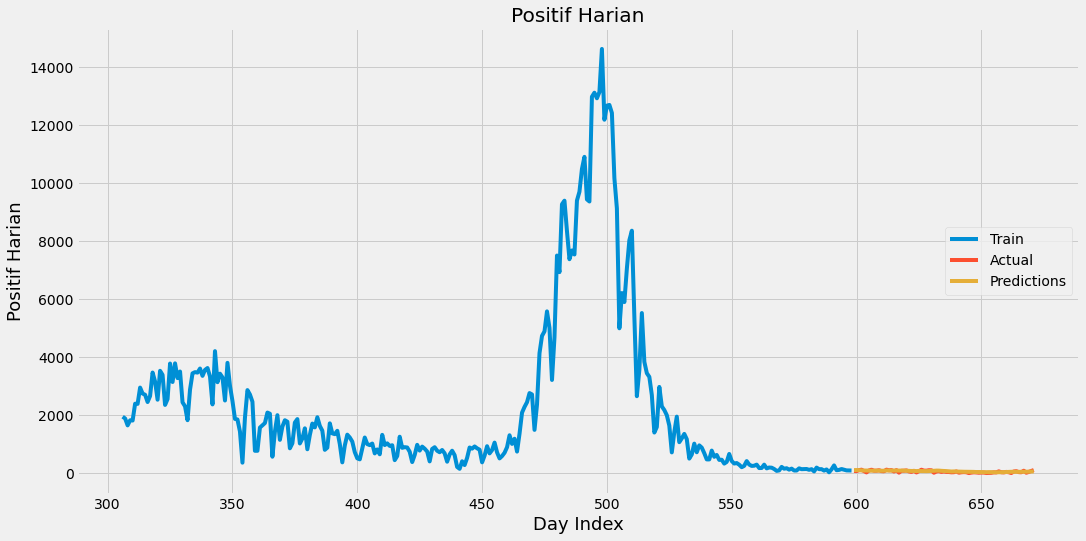

In [45]:
plt.figure(figsize=(16,8))
plt.title('Positif Harian')
plt.xlabel('Day Index', fontsize=18)
plt.ylabel('Positif Harian', fontsize=18)
plt.plot(train['Positif Harian'])
plt.plot(valid[['Positif Harian', 'Predictions_Positif_1']])
plt.legend(['Train', 'Actual', 'Predictions'], loc='right')
plt.show()

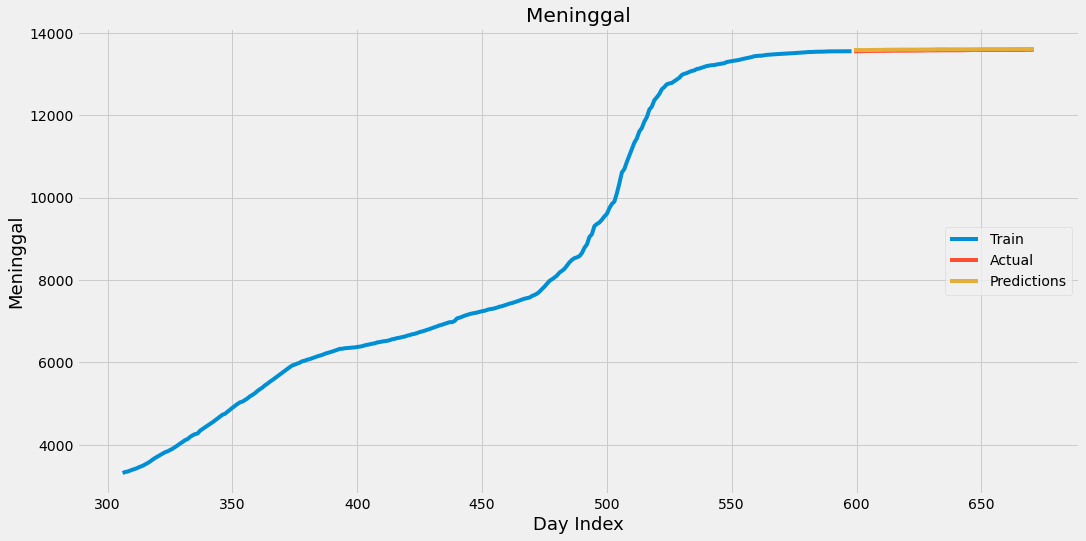

In [46]:
plt.figure(figsize=(16,8))
plt.title('Meninggal')
plt.xlabel('Day Index', fontsize=18)
plt.ylabel('Meninggal', fontsize=18)
plt.plot(train['Meninggal'])
plt.plot(valid[['Meninggal', 'Predictions_Meninggal_1']])
plt.legend(['Train', 'Actual', 'Predictions'], loc='right')
plt.show()

In [47]:
# tfjs.converters.save_keras_model(loaded_model_1, "model_final_js")